# Decomposição em valores singulares (SVD ou singular value decomposition)

<i>Créditos: grande parte deste notebook foi traduzido de https://github.com/fastai/numerical-linear-algebra</i>

## Aplicação: modelagem de tópicos

Uma aplicação importante de fatoração de matrizes é a modelagem de tópicos. Seja a **matriz termos por documentos**:

<img src="images/document_term.png" alt="term-document matrix" style="width: 80%"/>
(Source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#))

Podemos decompô-la em uma matriz alta e magra multiplicada por uma matriz curta e larga (possivelmente com uma matriz diagonal no meio).

Note que esta representação não leva em conta a ordem das palavras ou a estrutura da frase. Este é um exemplo de abordagem **bag of words**.

## Motivação

Considere o caso mais extremo: reconstruir a matriz usando um produto externo de dois vetores. Claramente, na maior parte dos casos não seremos capazes de reconstruir a matriz de maneira exata. Porém, usando um vetor com a frequência relativa de cada palavra e um com o número de palavras por documento, então o produto externo vai estar quase tão perto quanto possível.

Agora considere aumentar estas matrizes para duas colunas e duas linhas. A decomposição ótima agora seria agrupar (clusterizar) os documentos em dois grupos, cada um com uma distribuição de palavras tão diferente quanto possível da outra, mas tão similar quanto possível aos outros documentos no grupo. Nós iremos chamar estes dois grupos de "tópicos". Vamos agrupar as palavras em dois grupos, baseados naqueles que aparecem mais frequentemente em cada um dos tópicos.

## No restante da aula de hoje

Vamos pegar um dataset de documentos com categorias diferentes, encontrar os tópicos (que consistem em grupos de palavras) para eles. Neste caso, conhecer as categorias reais nos ajuda a avaliar se os tópicos encontrados fazem sentido.

Iremos fazer isso através do **Singular Value Decomposition (SVD)**.

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

## Material suplementar
- [Data source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html): Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.
- [Chris Manning's book chapter](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) on matrix factorization and LSI 
- Scikit learn [truncated SVD LSI details](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

### Outros tutoriais
- [Scikit-Learn: Out-of-core classification of text documents](http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html): uses [Reuters-21578](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection) dataset (Reuters articles labeled with ~100 categories), HashingVectorizer
- [Text Analysis with Topic Models for the Humanities and Social Sciences](https://de.dariah.eu/tatom/index.html): uses [British and French Literature dataset](https://de.dariah.eu/tatom/datasets.html) of Jane Austen, Charlotte Bronte, Victor Hugo, and more

## Preparando os dados

Scikit Learn vem com vários datasets incluídos, além de ferramentas de carregamento para carregar diversos datasets externos padrão. Este é um [ótimo recurso](http://scikit-learn.org/stable/datasets/). Os Datasets incluem preços das moradias em Boston, imagens faciais, patches de floresta, diabetes, câncer de mama, e outros. Vamos usar o dataset de newsgroups.

Newsgroups são grupos de discussão criados no Usenet, que era uma rede popular nos anos 80 e 90 antes da web realmente estourar. Este dataset inclui 18000 posts em newsgroups espalhados em 20 tópicos.  

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Vamos dar uma olhada nos dados. Você consegue advinhar em que categoria estão estas mensagens?

In [8]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

**Dica**: Definition of perijove. plural -s. : the point in the orbit of a satellite of Jupiter nearest the planet's center — compare apojove.

Source: Merriam-Webster

In [9]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], 
      dtype='|S18')

O atributo *target* é o índice da categoria (número inteiro).

In [10]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

A seguir, usaremos um método do scikit learn que irá calcular todos os *word counts* (contagem de palavras).

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26577)

In [13]:
print(len(newsgroups_train.data), vectors.shape)

(2034, (2034, 26577))


In [14]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

In [ ]:
vocab[7000:7020]

## Singular Value Decomposition

"SVD is not nearly as famous as it should be." - Gilbert Strang

Nota: Vamos assumir que as entradas das matrizes são números reais.

É de se esperar que as palavras que aparecem com mais frequência em um tópico apareçam com menos frequência no outro - caso contrário a palavra não seria uma boa escolha para separar os dois tópicos. Portanto, esperamos que os tópicos sejam **ortogonais**.

O algoritmo SVD fatora uma matriz em uma matriz com **colunas ortogonais** e uma com **linhas ortogonais**, em conjunto  com uma matriz diagonal, que contém a **importância relativa** de cada fator).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD é uma **decomposição exata**, dado que as matrizes que ela retorna são grandes o suficiente para cobrir a matriz original inteira. SVD é extremamente utilizado em álgebra linear, e especificamente em ciência dos dados para:

- análise semântica
- filtragem colaborativa / sistemas de recomendação ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calcular a pseudo-inversa Moore-Penrose
- compressão de dados
- principal component analysis

O SVD pode ser visto como uma generalização da decomposição espectral (em autovalores e autovetores) para matrizes não-quadradas. A ideia é encontrar a fatorar a matriz $A_{m \times n}$ em

$$A = U \Sigma V^\top$$

onde:
 * $U$ é uma matriz ortogonal $m \times m$;
 * $\Sigma$ é uma matriz retangular diagonal $m \times n$ com números reais não-negativos na diagonal;
 * $V$ é uma matriz ortogonal $n \times n$.
 
Os elementos da diagonal de $\Sigma$ são chamados valores singulares de $A$. As colunas de $U$ e de $V$ são chamadas vetores singulares esquerdos (*left singular vectors*) e direitos (*right singular vectors*) de $A$, respectivamente.

**Observação:** quando $m > n$, as colunas $n+1,\ldots,m$ de $U$ serão multiplicadas pelos zeros de $\Sigma$. Na prática, utilizamos a versão reduzida do SVD, onde $U$ é $m \times n$ e $\Sigma$ é $n \times n$.  

In [17]:
%time U, s, Vt = linalg.svd(vectors, full_matrices=False)

CPU times: user 48.4 s, sys: 2.27 s, total: 50.7 s
Wall time: 27.8 s


In [ ]:
print(U.shape, s.shape, Vt.shape)

Confirme que esta é uma decomposição da entrada.

In [ ]:
#Resposta:

Confirme que U e V são ortogonais.

In [ ]:
#Resposta:

## Tópicos

O que podemos dizer a respeito dos valores singulares $s$?

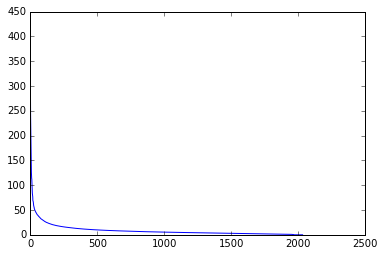

In [18]:
plt.plot(s);

In [19]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [20]:
show_topics(Vt[:10])

[u'ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 u'jpeg gif file color quality image jfif format',
 u'graphics edu pub mail 128 3d ray ftp',
 u'jesus god matthew people atheists atheism does graphics',
 u'image data processing analysis software available tools display',
 u'god atheists atheism religious believe religion argument true',
 u'space nasa lunar mars probe moon missions probes',
 u'image probe surface lunar mars probes moon orbit',
 u'argument fallacy conclusion example true ad argumentum premises',
 u'space larson image theory universe physical nasa material']

Nós obtivemos tópicos que casam com os tipos de clustes que espávamos! Isto acontece apesar deste ser um **algoritmo não-supervisionado**, ou seja, nunca dissemos para o algoritmo como é que os documentos estavam agrupados.

In [51]:
target_names = np.array(newsgroups_train.target_names)[newsgroups_train.target[:10]]
print(target_names)

['comp.graphics' 'talk.religion.misc' 'sci.space' 'alt.atheism' 'sci.space'
 'alt.atheism' 'sci.space' 'comp.graphics' 'sci.space' 'comp.graphics']


In [67]:
yhat = (U[0,:]*s).dot(Vt)

num_doc_words = 5
inds = np.argsort(yhat)[:-num_doc_words-1:-1]
print(inds)

[10287  1152 19067  8554 10606]


In [68]:
vocab[inds]

array([u'file', u'3ds', u'prj', u'does', u'format'], 
      dtype='<U80')

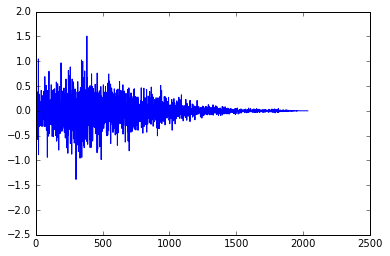

In [70]:
Us = U[0,:]*s
plt.plot(Us)

In [72]:
np.argmax(Us)

383

In [74]:
show_topics(Vt[383:384])

[u'read file koran linux mode given list interesting']